### Imports

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

### Utils

In [4]:
def show_image(img, size=(40, 6), title=None):
    plt.figure(figsize=size)
    plt.axis('off')
    
    if title is not None:
        plt.title(title)
    
    plt.imshow(img, cmap="gray", vmin=0, vmax=1)
    plt.show()
    
def read_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img // 255
    return img

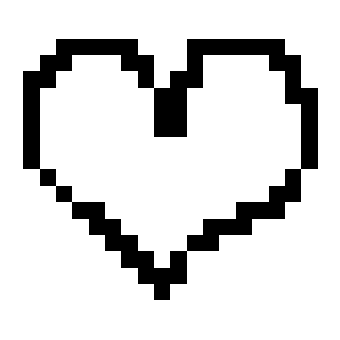

In [12]:
img = read_image('images/heart_20.png')
show_image(img)

In [6]:
# Moves
'''
8 1 2
7 0 3
6 5 4
'''
moves = [
    (0, 0), (-1, 0), (-1, 1),
    (0, 1), (1, 1), (1, 0),
    (1, -1), (0, -1), (-1, -1),
]

# Costs of rotations.
rotation_costs = [0, 1, 1, 5, 9, 5, 1, 1]
rot_cost_mean = sum(rotation_costs) // len(rotation_costs)
rot_count_prob = (np.array(rotation_costs) > 0).sum() / ( len(rotation_costs) + 1)
rot_step_count_cost = 1 / rot_count_prob

# Meta
non_empty_pixels = (img == 0).sum()
bound_row = img.shape[0] - 1
bound_col = img.shape[1] - 1

# Hyperparameters
candidate_size = int(non_empty_pixels * 1.35) # size of a candidate solution
pop_size = 4096 # candidate count per iteration
mut_prob = 0.1 # probability of mutation
mut_decay = 0.001 # decay of mutation ratio per generation
max_gen = 1024 # maximum generation
cross_pick_strength = 2 # strengh of an fitness order to be picked to crossover
cross_point = 3 # split points of crossover
gen_keep = int(pop_size * 0.7) # number of best candidates to keep
gen_renew = pop_size - gen_keep
ft_round = 6

# Weights
weights = [
    1.0, # w_density_cost
    1.0, # w_inv_mov_loss
    1.2, # w_rotate_loss
    1.2, # w_rotate_cost
    2.0, # w_overlap_loss
    2.4, # w_spread_loss
    1.8, # w_paint_loss
]

# Normalize weights.
weights /= np.array(weights).sum()

# Configurations
log_interval = 1
show_interval = 10

print(f'non_empty_pixels={non_empty_pixels}')
print(f'candidate_size={candidate_size}')
print(f'mutation_size={candidate_size*mut_prob}')
print(f'gen_keep={gen_keep}')
print(f'gen_renew={gen_renew}')

non_empty_pixels=107
candidate_size=133
mut_size=13
gen_keep=1024
gen_renew=3072


[0.00032464 0.00032072 0.00031419 ... 0.00021121 0.0002111  0.00021082]
Gen#0 ft=1.7821200196753566 bestgen=0


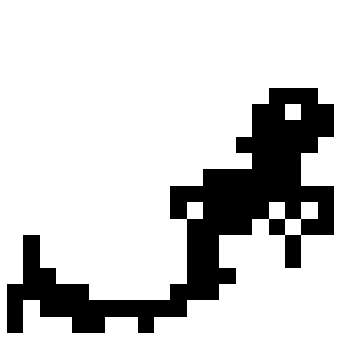

In [7]:
# Create number random generator
rng = np.random.default_rng()

# Create initial population.
population = np.random.randint(1, 9, (pop_size, candidate_size))

# Keep track of gen's best.
fit_of_gen_best = np.inf
gen_of_gen_best = 0
fit_of_last_best = np.inf

# Constants
side_size = img.shape[0]
side_inner_size = side_size - 2
max_solution_density = (3 * 4) + (5 * 4 * side_inner_size) + (8 * side_inner_size**2)

# Iterate generations.
for gen in range(max_gen):    
    fitnesses = np.full(pop_size, np.inf)
    
    # Keep best solution to show.
    best_fitness = np.inf
    best_solution = None
    
    # Calculate fitness of each candidate
    for ci, candidate in enumerate(population):
        # Fitness of candidate
        ft_density_cost = 0
        ft_inv_mov_loss = 0
        ft_rotate_loss = 0
        ft_rotate_cost = 0
        ft_overlap_loss = 0
        ft_spread_loss = 0
        ft_paint_loss = 0
        
        # Create solution of this candidate.
        solution = np.ones(img.shape)
        inverse_moves = 0
        
        # Start point for solution.
        prev_mov_dir = candidate[0]
        row = side_size - 1 
        col = 0
        for direction in candidate:
            # Paint pixel if in bound.
            if (0 <= row <= bound_row) and (0 <= col <= bound_col):
                solution[row][col] = 0
            
            # Calculate rotation cost.
            if direction != prev_mov_dir:
                rotate_costs = np.roll(rotation_costs, prev_mov_dir - 1)
                step_rotate_cost = rotate_costs[direction - 1]
                ft_rotate_cost += step_rotate_cost / rot_cost_mean
                ft_rotate_loss += rot_step_count_cost
                
                if abs(direction - prev_mov_dir) == 4:
                    inverse_moves += 1
                
            prev_mov_dir = direction
            
            # Findout next position.
            move = moves[direction]
            next_row = row + move[0]
            next_col = col + move[1]
            if (0 <= next_row <= bound_row) and (0 <= next_col <= bound_col):
                row = next_row
                col = next_col
        
        # Calculate inverse movement loss.
        ft_inv_mov_loss = inverse_moves / (candidate_size / 8)
           
        # Normalize rotation cost of candidate.
        ft_rotate_cost /= candidate_size
        ft_rotate_loss /= candidate_size

        # Calculate overlap rate fitness.
        overlap = (np.logical_or(solution, img) == False).sum()
        ft_overlap_loss = 1 - (overlap / non_empty_pixels)
        
        # Calculate spread loss fitness.
        ft_spread_loss = (non_empty_pixels - overlap) / non_empty_pixels
        
        # Calculate paint loss fitness. 
        non_empy_solution = (solution == 0).sum()
        ft_paint_loss = (non_empty_pixels - non_empy_solution) / non_empty_pixels
        
        # Calculate density cost.
        inverse_solution = 1 - solution
        padded = np.pad(inverse_solution, ((1,1),(1,1)), mode='constant')
        # - Generate shifted versions of solution in every direction.
        shift_bo = padded[0:side_size+0, 1:side_size+1]
        shift_to = padded[2:side_size+2, 1:side_size+1]
        shift_ri = padded[1:side_size+1, 0:side_size+0]
        shift_le = padded[1:side_size+1, 2:side_size+2]
        shift_bl = padded[0:side_size+0, 2:side_size+2]
        shift_br = padded[0:side_size+0, 0:side_size+0]
        shift_tl = padded[2:side_size+2, 2:side_size+2]
        shift_tr = padded[2:side_size+2, 0:side_size+0]
        # - Calculate density by summing all neighbour of every pixel.
        density_map = (shift_bo + shift_to + shift_ri +
                       shift_le + shift_bl + shift_br +
                       shift_tl + shift_tr)
        # - Normalize density cost.
        ft_density_cost = round(density_map.sum() / max_solution_density, ft_round)
        
        # Calculate total fitness.
        losses = [
            ft_density_cost,
            ft_inv_mov_loss, ft_rotate_loss, ft_rotate_cost,
            ft_overlap_loss, ft_spread_loss, ft_paint_loss
        ]
        fitness = (weights * losses).sum()
        fitnesses[ci] = fitness

        # Keep if best candidate.
        if fitness < best_fitness:
            best_fitness = fitness
            best_solution = solution   
    
    # Order the candidates by their fitness.
    fitnesses = np.round(fitnesses, ft_round)
    orders = fitnesses.argsort()
    fitnesses = fitnesses[orders]
    population = population[orders] 
    
    # Scale fitnesses.
    # Use roulette wheel selection.
    # ft_scaled = fitnesses
    # Use order selection with pick strength.
    ft_scaled = np.arange(1, (pop_size * cross_pick_strength + 1), cross_pick_strength) 
    
    # Calculate weight distribution of candidates.
    ft_probs = 1 / ft_scaled
    ft_probs = ft_probs / ft_probs.sum()
    
    # Create 2n pairs by weighted random (fitness)
    pairs_len = pop_size * 2
    pairs = population[np.random.choice(population.shape[0], pairs_len, p=ft_probs)]
    
    # Crossover and Mutate to create new candidates.
    new_population = []
    for i in range(0, pairs_len, 2):
        # Crossover 
        a = pairs[i]
        b = pairs[i+1]
        # Generate random split points.
        splits = rng.choice(candidate_size, size=cross_point, replace=False)
        splits.sort()
        # Split parents.
        a = np.split(a, splits, axis=0)
        b = np.split(b, splits, axis=0)
        pair = [a, b]
        # Pick parts randomly from parents.
        picks = np.random.randint(0, 2, cross_point + 1)
        new_candidate = [x for i, p in enumerate(picks) for x in pair[p][i]]
        
        # Add candidate to new population.
        new_population.append(new_candidate)
        
    # Keep some of current generation and fill rest with new.
    population[gen_keep:] = new_population[:gen_renew]
    
    # Mutate
    gen_mut_prob = mut_prob * ((1 - mut_decay) ** gen)
    mutation_points = np.random.rand(pop_size, candidate_size) < gen_mut_prob
    mutations = np.random.randint(1, 9, (pop_size, candidate_size))
    population[mutation_points] = mutations[mutation_points]
       
    # Stats for current gen.
    last_gen_best = fit_of_gen_best
    curr_gen_best = fitnesses[0]
    
    # Log generation stats.
    if gen % log_interval == 0:
        print(
            f'Gen#{gen} ft={curr_gen_best} '
            f'(last same={curr_gen_best == fit_of_last_best} ft={fit_of_last_best}) '
            f'(best same={curr_gen_best == fit_of_gen_best} gen={gen_of_gen_best} ft={fit_of_gen_best})'
        )
    
    # Show the best candidate.
    if gen % show_interval == 0:
        show_image(best_solution)
    
    # Update stats.
    fit_of_last_best = curr_gen_best
    if curr_gen_best < fit_of_gen_best:
        fit_of_gen_best = curr_gen_best
        gen_of_gen_best = gen

# Show final results.
print('\nDone.')
print(f'lastft={fit_of_last_best} bestft={fit_of_gen_best} bestgen={gen_of_gen_best}')
show_image(best_solution)